In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, ConcatDataset
from pytorch_ood.model import WideResNet
from pytorch_ood.detector import MaxSoftmax
from pytorch_ood.utils import OODMetrics
from pytorch_ood.dataset.img import LSUNResize

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

import pickle
import numpy as np
from tqdm import tqdm


## Create Neural Network
device = "cuda" if torch.cuda.is_available() else "cpu"
model = WideResNet(num_classes=10, pretrained="cifar10-pt")
model.eval().to(device)
# Create detector
detector = MaxSoftmax(model)
# Instantiate metrics
metrics = OODMetrics()

## Define Test Set
trans = WideResNet.transform_for("cifar10-pt")
norm_std = WideResNet.norm_std_for("cifar10-pt")
# Load CIFAR-10 test set
cifar10_test = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=trans)
# Load LSUN test set
lsun_test = LSUNResize(root="./data", download=True, transform=trans)

Files already downloaded and verified


In [ ]:
# Extract labels
cifar10_test_labels = [label for _, label in cifar10_test]
cifar10_cls_name = cifar10_test.classes
unique_labels = set(cifar10_test_labels)
for label in sorted(unique_labels):
    print(f"Label {label}: {cifar10_cls_name[label]}")
    
# Attempt to extract labels from the LSUN Resized dataset
lsun_labels = [label for _, label in lsun_test]
unique_lsun_labels = set(lsun_labels)
print("Unique labels in LSUN Resized dataset:", unique_lsun_labels)

In [8]:
## Perform OOD detection
test_loader = DataLoader(cifar10_test+lsun_test, batch_size=128, shuffle=False)
all_scores, all_labels = [],[]
with torch.no_grad():
    for data, labels in tqdm(test_loader, desc="Processing batches"):
        outputs = detector(data.to(device))
        scores = outputs.cpu().numpy()
        all_scores.extend(scores)
        
        labels = labels.cpu().numpy()
        binary_labels = np.where(labels >= 0, 0, 1)
        all_labels.extend(binary_labels)
        # Update metrics
        metrics.update(outputs, torch.tensor(labels))
# Print results
result = metrics.compute()
print('MSP Result: ', result)

Processing batches: 100%|██████████| 157/157 [00:11<00:00, 13.71it/s]

MSP Result:  {'AUROC': 0.9107536673545837, 'AUPR-IN': 0.9226487278938293, 'AUPR-OUT': 0.8906269073486328, 'FPR95TPR': 0.3041999936103821}


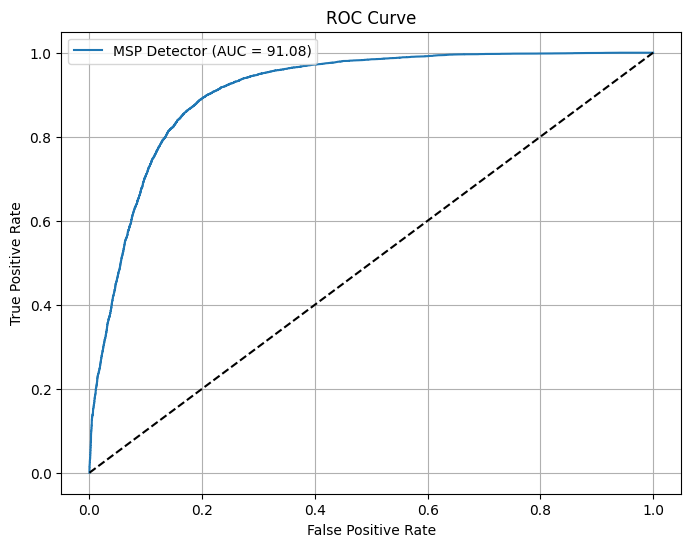


OOD Detection Metrics:
AUROC: 0.91% ↑
AUPR-IN: 0.92% ↑
AUPR-OUT: 0.89% ↑
FPR95TPR: 0.30% ↓


In [9]:
## Plot ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label="MSP Detector (AUC = {:.2f})".format(roc_auc*100))
plt.plot([0,1],[0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Save results
with open("msp_result.pkl", "wb") as f:
    pickle.dump({
        'scores': all_scores,
        'labels': all_labels,
        'metrics': result,
        'fpr': fpr,
        'tpr': tpr,
    },f)
    
# Print result:
print("\nOOD Detection Metrics:")
for k, v in result.items():
    direction = '↑' if 'AU' in k else '↓'
    print(f"{k}: {v:.2f}% {direction}")